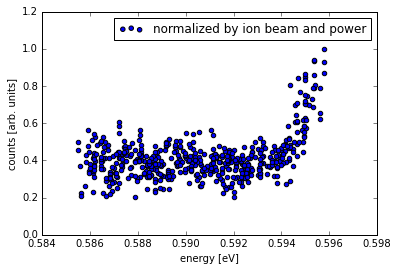

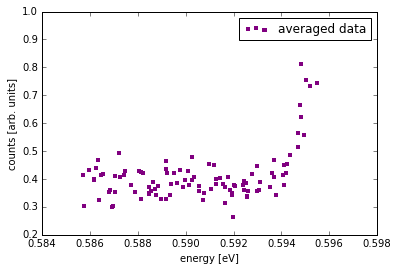

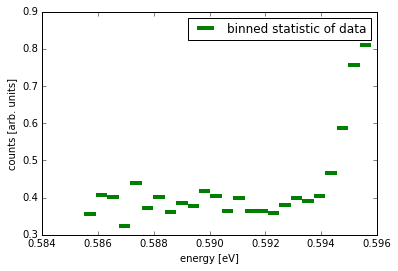

{'energy': 0.5937511111144261, 'energy_error': 0.0001778038099361968}
the energy after Doppler shift is: 0.5935410677855233 0.0001777409106785255


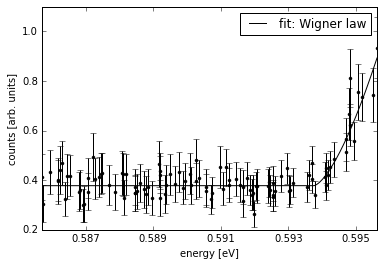

In [274]:
import pandas as pd 
import numpy as np
import glob
import math
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
from scipy.optimize import curve_fit
import scipy.stats as stats


df = pd.read_csv(r'/Users/mac/Desktop/Gunilla/Rh_total_data/16_01_2023_2075_to_2110_105_steps.h5.txt', delimiter=" ", skiprows=0)
#df = pd.read_csv(r'/Users/mac/Desktop/Gunilla/Rh_total_data/17_01_2023_2075_to_2110_105_steps2.h5.txt', delimiter=" ", skiprows=0)



#Calculate energy from frequency in THz
x = 1239.842/532.2 - df["frequency"]*4.135667516e-3 

#Calculate Signal: Number of counts
df['counts'] = df['A_Counts']-df['B_Counts']

#Normalize the signal by the ion current and laser power
norm = (df['Power_[W]']*df['ion_beam'])
y = df['counts']/norm
#y = df['counts']/df['Power_[W]']
#y = df['counts']/df['ion_beam']
#y= df['counts']

#Normalizing the cross section to 1.
y_norm = y/y.max()
#y_norm = y

#Error propagation: 
counts_sd = np.sqrt(df['counts'])
x_sd = df['frequency_std']*4.135667516e-3 
y_sd = np.sqrt((counts_sd/(df['Power_[W]']*df['ion_beam']))**2+((df['counts']*df['ion_beam_std'])/(df['Power_[W]']*df['ion_beam']**2))**2+((df['counts']*df['Power_[W]_std'])/(df['ion_beam']*df['Power_[W]']**2))**2)/y.max()
#Error propagation excluding ion beam
#y_sd = np.sqrt((counts_sd/df['Power_[W]'])**2+((df['counts']*df['Power_[W]_std'])/df['Power_[W]']**2)**2)/y.max()
#Error propagation excluding power
#y_sd = np.sqrt((counts_sd/df['ion_beam'])**2+((df['counts']*df['ion_beam_std'])/df['ion_beam']**2)**2)/y.max()

#Plotting original data
plt.xlabel("energy [eV]")
plt.ylabel("counts [arb. units]")
#plt.scatter(x ,y_norm, label='normalized by power')
#plt.scatter(x ,y_norm, label='normalized by ion beam')
plt.scatter(x ,y_norm, label='normalized by ion beam and power')
#plt.scatter(x ,y_norm, label='not normalized')
plt.legend()
plt.show()

#Binning data by averaging every n values
def binning(n, x):
    return [sum(x[a:a+n])/n for a in range(0,len(x),n)]

def binning_error(n, x):
    return [np.sqrt(sum((x[c:c+n])**2)/n) for c in range(0,len(x),n)]

n=5
x_avg, y_avg, x_err, y_err = binning(n, x), binning(n, y_norm), binning_error(n, x_sd), binning_error(n, y_sd)


plt.scatter(x_avg, y_avg, marker = '_', c='purple',linewidths = 4, label = 'averaged data')
plt.xlabel("energy [eV]")
plt.ylabel("counts [arb. units]")
plt.legend()
plt.show()

#Binning data using binned_statistics
bin_means,bin_edges, binnumber = stats.binned_statistic(x, y_norm,statistic= "mean", bins=25)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=4, label='binned statistic of data')
bin_edges_x = (bin_edges[:-1]+bin_edges[1:])/2
plt.xlabel("energy [eV]")
plt.ylabel("counts [arb. units]")
plt.legend()
plt.show()
#plt.scatter(bin_edges_x, bin_means, marker = '_', c='b',linewidths = 4, label='binned statistic of data middle point' )
#plt.scatter(x_av, y_avg, marker = '_', c='purple',linewidths = 4, label = 'averaged data' )
#plt.figure()

#Fitting our data to the Wigner law.
# In this case we consider l=1
def Wigner_law(x, A, E, B):  
    return A  + B * (0.5*(np.abs(x - E)+(x - E)))**(3/2)

#Fitting using binned_statistics
#binparam, bincov = curve_fit(Wigner_law,bin_edges, bin_means, sigma = y_err, absolute_sigma=True,  maxfev=500000, p0=[0.4,0.594,0.9])
#Fitting using averaged counts
binparam, bincov = curve_fit(Wigner_law, x_avg, y_avg, sigma = y_err ,absolute_sigma=True,  maxfev=500000, p0=[0.4,0.590,0.6])
#Fitting using original data:
#binparam, bincov = curve_fit(Wigner_law, x, y_norm, sigma = y_sd ,absolute_sigma=True,  maxfev=500000, p0=[0.1,0.594,1.0]
# fit parallel data
#sigma = err,
# std deviation
binerr = np.sqrt(np.diag(bincov))

threshold = {'energy': binparam[1], 'energy_error' : binerr[1]}
print(threshold)


def Doppler_shift(EA_shifted,geom, E_kin_eV, mass_ion_u):
    v_ion= np.sqrt((2* E_kin_eV/6.24150913e18) / (mass_ion_u *1.66053904e-27))
    beta = v_ion/scipy.constants.c
    #co_prop
    if geom == 1:
        EA = EA_shifted*np.sqrt((1-beta)/(1+beta))
    #counter
    else:
        EA = EA_shifted*np.sqrt((1+beta)/(1-beta))
    return EA

energy_shifted = Doppler_shift(binparam[1], 1, 6000, 102.905504)
energy_shifted_er = Doppler_shift(binerr[1], 1, 6000, 102.905504)
print('the energy after Doppler shift is:', energy_shifted, energy_shifted_er)
x_data = np.linspace(min(x_avg),max(x_avg),400)
#e_data = 
plt.plot(x_data, Wigner_law(x_data,*binparam), label='fit: Wigner law', c='black')
plt.xlabel("energy [eV]")
plt.ylabel("counts [arb. units]")
plt.xticks(np.arange(0.585,0.596, step=0.002))
#plt.errorbar(x_avg, y_avg, y_sd22,fmt='o',ecolor='black', label= 'errors using avg. values' )
plt.errorbar(x_avg, y_avg, y_err,fmt='.k',ecolor='black' )
#plt.scatter(bin_edges_x, bin_means)
#plt.scatter(x_avg, y_avg, s = 2, marker = 'o', c='black',linewidths = 3 )
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=4, label='binned statistic of data')
plt.legend()
plt.show()




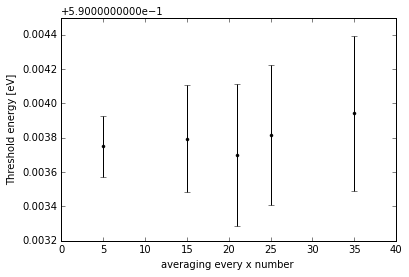

In [275]:
#Energies and its errors according to the number of bins.
avg = [25, 5, 15, 35, 21]
bins = [21, 105, 35, 15, 25]
t_en = [0.5938161973834697, 0.5937511111144261, 0.5937956533972261, 0.5939426361063979, 0.593699755172]
t_en_er = [0.0004067041157683247, 0.0001778038099361968, 0.0003115731279722634,  0.00044977879974764096, 0.0004156455204344367]

#x_vals = np.linspace(0, len(t_en),len(t_en))
plt.ylim(0.5932,0.59450)
plt.xlim(0,40)
plt.errorbar(avg, t_en,yerr = t_en_er, fmt=".k")
plt.xlabel('averaging every x number ')
plt.ylabel('Threshold energy [eV]')
plt.show()


weighted mean of energies excluding outlier is:  (0.5886932001534854, 0.000382967596625914)
weighted mean of energies including outlier is:  (0.5926818933019368, 0.00016122312616332203)


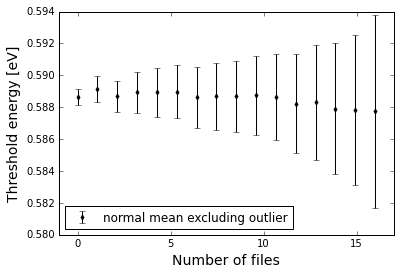

In [228]:
#Energy values excluding outlier
energie = [0.5867535670312543, 0.5892484181263589, 0.5864608351071366, 0.5891614109072216, 0.5892415270413434, 0.5896154827170113, 0.5829647559401755, 0.5863832833981565, 0.5889249752490375, 0.5878681918833211, 0.5877049994550455, 0.5886469650941935, 0.5895915121316818, 0.5886218152213156, 0.5836968200512378, 0.5891294933670448]
energie_errors = [0.015970429196149997, 0.002202331685170952, 0.002951796357347124, 0.00312806901979481, 0.004048705592154118, 0.0019682825995076115, 0.008249018011331346, 0.00948937950698566, 0.002193446213790884, 0.0012257534131407065, 0.004474415280996669, 0.000496698865290104, 0.0010421828984208729, 0.0031434914413320707, 0.005770558540023164, 0.007521689048140911]

#Energy values including outlier 
energie_o = [0.5935410677855233, 0.5867535670312543, 0.5892484181263589, 0.5864608351071366, 0.5891614109072216, 0.5892415270413434, 0.5896154827170113, 0.5829647559401755, 0.5863832833981565, 0.5889249752490375, 0.5878681918833211, 0.5877049994550455, 0.5886469650941935, 0.5895915121316818, 0.5886218152213156, 0.5836968200512378, 0.5891294933670448]
energie_errors_o = [0.0001777409106785255, 0.015970429196149997, 0.002202331685170952, 0.002951796357347124, 0.00312806901979481, 0.004048705592154118, 0.0019682825995076115, 0.008249018011331346, 0.00948937950698566, 0.002193446213790884, 0.0012257534131407065, 0.004474415280996669, 0.000496698865290104, 0.0010421828984208729, 0.0031434914413320707, 0.005770558540023164, 0.007521689048140911]


#sorting the lists 
energia_errors, energia = (list(t) for t in zip(*sorted(zip(energie_errors, energie))))
energia_errors_o, energia_o = (list(t) for t in zip(*sorted(zip(energie_errors_o, energie_o))))

def weighted(energy, energy_errors):
    w_i = [1/energy_errors[i]**2 for i in range(len(energy_errors))]
    e_w = sum(w_i[j]*energy[j] for j in range(len(energy)))/sum(w_i)
    err_w = np.sqrt(1/sum(w_i))
    return e_w, err_w

def promedio(energy, energy_errors):
    prom = sum(energy)/len(energy)
    cuad = [energy_errors[i]**2 for i in range(0, len(energy_errors))]
    prom_er = np.sqrt(sum(cuad)/len(cuad))
    return prom, prom_er

print('weighted mean of energies excluding outlier is: ', weighted(energia, energia_errors))
print('weighted mean of energies including outlier is: ', weighted(energia_o, energia_errors_o))
#print(promedio(energia, energia_errors))

suma_weighted = [weighted(energia[0:i+1], energia_errors[0:i+1])[0] for i in range(len(energia))] 
suma_promedio = [promedio(energia[0:i+1], energia_errors[0:i+1])[0] for i in range(len(energia))]
suma_weighted_err = [weighted(energia[0:i+1], energia_errors[0:i+1])[1] for i in range(len(energia))] 
suma_promedio_err = [promedio(energia[0:i+1], energia_errors[0:i+1])[1] for i in range(len(energia))]

suma_weighted_o = [weighted(energia_o[0:i+1], energia_errors_o[0:i+1])[0] for i in range(len(energia_o))] 
suma_promedio_o = [promedio(energia_o[0:i+1], energia_errors_o[0:i+1])[0] for i in range(len(energia_o))]
suma_weighted_err_o = [weighted(energia_o[0:i+1], energia_errors_o[0:i+1])[1] for i in range(len(energia_o))] 
suma_promedio_err_o = [promedio(energia_o[0:i+1], energia_errors_o[0:i+1])[1] for i in range(len(energia_o))]


#plotting the errors
x_vals = np.linspace(0, len(energia),len(energia))
x_vals_o = np.linspace(0, len(energia_o),len(energia_o))
#plt.ylim(0.0079,0.58)
plt.xlim(-1, 17)
#PLotting without outlier
#plt.errorbar(x_vals, suma_weighted, yerr = suma_weighted_err,fmt="dk", ms = 4, capsize=3, ecolor="black", elinewidth=1, label = 'weighted mean excluding outlier')
plt.errorbar(x_vals, suma_promedio, yerr = suma_promedio_err, fmt="dk", ms = 4, capsize=3, ecolor="black", elinewidth=1,  label = 'normal mean excluding outlier' )
#plt.errorbar(x_vals, energia, yerr = energia_errors, fmt="dk", ms = 4, capsize=3, ecolor="black", elinewidth=1, label = 'energy, from smallest to largest error')
#Plotting with outlier
#plt.errorbar(x_vals_o, suma_weighted_o, yerr = suma_weighted_err_o,fmt="dk", ms = 4, capsize=3, ecolor="black", elinewidth=1, label = 'weighted mean including outlier')
#plt.errorbar(x_vals_o, suma_promedio_o, yerr = suma_promedio_err_o, fmt="dk", ms = 4, capsize=3, ecolor="black", elinewidth=1,  label = 'mean including outlier' )
#plt.errorbar(x_vals_o, energia_o, yerr = energia_errors_o, fmt="dk", ms = 4, capsize=3, ecolor="black", elinewidth=1, label = 'energy, from smallest to largest error')
plt.xlabel('Number of files',fontsize=14)
plt.ylabel('Threshold energy [eV]', fontsize=14)
plt.legend(loc = 'lower left',  numpoints = 1)
plt.show()

In [100]:
import scipy.constants
def Doppler_shift(EA_shifted,geom, E_kin_eV, mass_ion_u):
    v_ion= np.sqrt((2* E_kin_eV/6.24150913e18) / (mass_ion_u *1.66053904e-27))
    beta = v_ion/scipy.constants.c
    #co_prop
    if geom == 1:
        EA = EA_shifted*np.sqrt((1-beta)/(1+beta))
    #counter
    else:
        EA = EA_shifted*np.sqrt((1+beta)/(1-beta))
    return EA

In [30]:
Doppler_shift(0.5937511111144261, 1, 6000, 102.90549)

0.5935410677712379

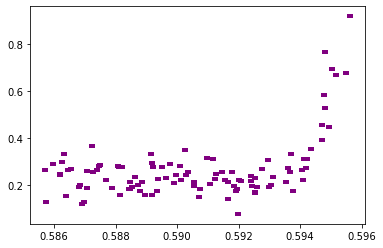

In [449]:
n = 5
x_avg = [sum(x[a:a+n])/n for a in range(0,len(x),n)]
y_avg = [sum(y_norm[b:b+n])/n for b in range(0,len(y_norm),n)]
x_sd_avg = [sum(x_sd[c:c+n])/n for c in range(0,len(x_sd),n)]
y_sd_avg = [sum(y_sd2[d:d+n])/n for d in range(0,len(y_sd2),n)]
plt.scatter(x_avg, y_avg, marker = '_', c='purple',linewidths = 4)

In [ ]:
#Data binning averaging every 5 counts
x_av, y_av, x_sd_av, y_sd_av  = [], [], [],[]
def binning_av(n, x, y, sd_x, sd_y):
    for a, b, c, d in zip(x, y, sd_x, sd_y):
        x_av.append(sum(x[a:a+n])/n for a in range(0,len(x),n))
        y_av.append(sum(y[b:b+n])/n for b in range(0,len(y),n))
        x_sd_av.append(sum(sd_x[c:c+n])/n for c in range(0,len(sd_x),n))
        x_sd_av.append(sum(sd_y[d:d+n])/n for d in range(0,len(sd_y),n))
    return(x_av, y_av, x_sd_av, y_sd_av)

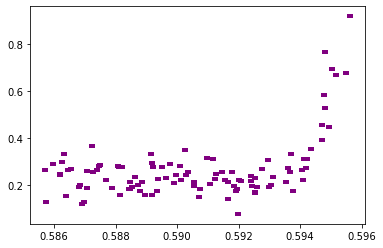

In [452]:
#Averaging every 5 counts...
n = 5
list2 = [sum(y_norm[i:i+n])/n for i in range(0,len(y_norm),n)]
#y_vals = list2.reverse()
x_av = [sum(x[j:j+n])/n for j in range(0,len(x),n)]
plt.scatter(x_av, list2, marker = '_', c='purple',linewidths = 4 )
#print(list2)
list_x = []
for i in x_av:
    list_x.insert(0,i)
#print(list_x)


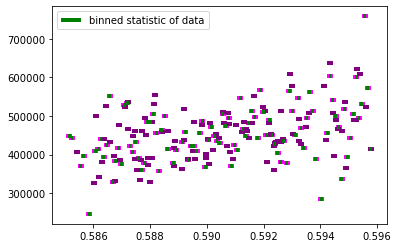

In [342]:
bin_means,bin_edges, misc = binned_statistic(x, counts_y,statistic= "mean", bins=105)
plt.figure()
#plt.plot(x,counts_y, 'b.', label='raw data')
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=4, label='binned statistic of data')
bin_edges_x = (bin_edges[:-1]+bin_edges[1:])/2
#plt.scatter(list_x, bin_means, marker = '_', c='magenta',linewidths = 1 )
plt.scatter(bin_edges_x, bin_means, marker = '_', c='magenta',linewidths = 4 )
plt.scatter(x_av, list2, marker = '_', c='purple',linewidths = 4 )
plt.legend()